In [1]:
from pennylane import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import pennylane as qml
import matplotlib.pyplot as plt
import seaborn as sns

# Table of contents
This notebook is organised as follows:

* [Load and analyse data](#load)
* [Define and plot circuits](#define)
    * [Fixed circuits](#fixed)
        * [Angle encoding kernel](#f1)
        * [Dense angle encoding kernel](#f2)
    * [Parametric circuits](#parametric)
        * [Circuit 1](#p1)
* [Compare kernels](#compare_kernels)
* [Compare accuracies](#compare_acc)
* [Conclusions](#conclusions)
* [Bibliography](#bib)

<a id='load'></a>
# Load and analyse data

In [2]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

Let's scale the data. Having each feature in $[0, \pi]$ is necessary to work with rotations.

In [3]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X) * np.pi

In [4]:
X.shape

(150, 4)

We can see that all three labels are perfectly balanced.

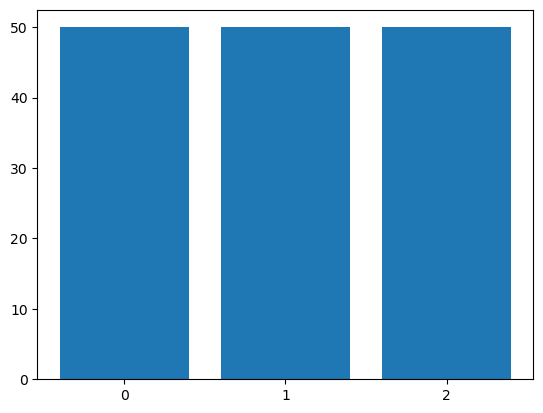

In [5]:
labels, counts = np.unique(y, return_counts=True)

plt.bar(labels, counts)
plt.xticks(labels)
plt.show()

In [6]:
np.random.seed(222)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)

<a id='define'></a>
# Define and plot circuits

All circuits are going to share the same underlying structure. This structure consists of an encoding step, which maps classical data to a quantum state, and an adjoint step that calculates the kernel between pairs of quantum states. The encoding step is going to be implemented using either fixed or parametric circuits, depending on the specific application. Fixed circuits use a predetermined circuit that maps the classical data to a quantum state, while parametric circuits use a variable circuit with tunable parameters that can be optimized during training to improve performance.


<a id='fixed'></a>
## Fixed circuits

<a id='f1'></a>
### Angle encoding

Let's start with a simple approach: A fixed circuit, just encoding the data with angle embedding.

In [7]:
n_qubits = X.shape[1]

dev = qml.device("lightning.qubit", wires=n_qubits)
wires = dev.wires.tolist()

def AngleEmb(x, wires):
    for i, wire in enumerate(wires):
        qml.RX(x[i], wires=[wire])

adjoint_AngleEmb = qml.adjoint(AngleEmb)

@qml.qnode(dev)
def kernel_circuit_1(x1, x2):
    AngleEmb(x1, wires=wires)
    adjoint_AngleEmb(x2, wires=wires)
    return qml.probs(wires=wires)

def kernel_1(x1, x2):
    return kernel_circuit_1(x1, x2)[0]

Lets see what the circuit does for two datapoints.

Twe two selected points have the same class: False
Kernel value between points: 0.0809781903762718


<Figure size 100x100 with 0 Axes>

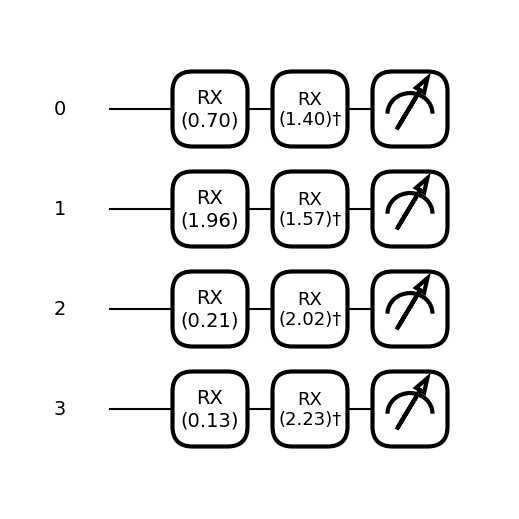

In [8]:
i,j = (0,70)
print(f"Twe two selected points have the same class: {y[i]==y[j]}")
print(f"Kernel value between points: {kernel_1(X[i], X[j])}")
fig = plt.figure(figsize=(1, 1))
qml.draw_mpl(kernel_circuit_1, decimals=2)(X[i],X[j])
plt.show()

<a id='f2'></a>
### Dense angle encoding

With this approach we need half as many qubits as with the previous method, at the cost of having twice as many layers.

In [9]:
dev2 = qml.device("lightning.qubit", wires=int(n_qubits/2))
wires2 = dev2.wires.tolist()

def DenseEmb(x, wires):
    for i, wire in enumerate(wires):
        qml.RX(x[i], wires=[wire])
        qml.RZ(x[2*i], wires=[wire])

adjoint_DenseEmb = qml.adjoint(DenseEmb)

@qml.qnode(dev2)
def kernel_circuit_2(x1, x2):
    DenseEmb(x1, wires=wires2)
    adjoint_DenseEmb(x2, wires=wires2)
    return qml.probs(wires=wires2)

def kernel_2(x1, x2):
    return kernel_circuit_2(x1, x2)[0]

Twe two selected points have the same class: False
Kernel value between points: 0.315798150405469


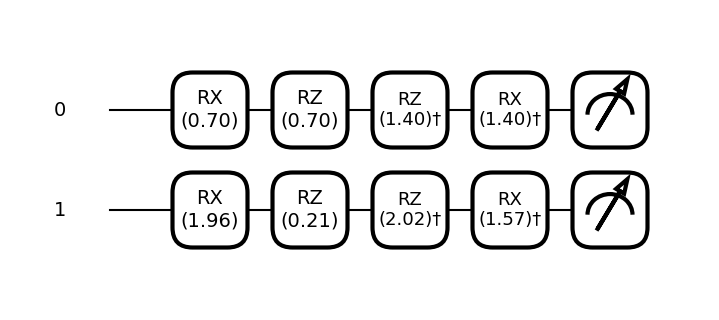

In [10]:
i,j = (0,70)
print(f"Twe two selected points have the same class: {y[i]==y[j]}")
print(f"Kernel value between points: {kernel_2(X[i], X[j])}")
qml.draw_mpl(kernel_circuit_2, decimals=2)(X[i],X[j])
plt.show()

<a id='parametric'></a>
## Parametric circuits

In this case the circuits are going to depend on some parametric gates with randomly initialized parameters, as well as on the values of the data points. We are going to uste the circuit proposed in [[1]](#qSVM1) and [[2]](#qSCM_training_kernels) with different number of layers.

In [11]:
def layer(x, layer_params, wires, i0=0, inc=1):
    """Building block of the embedding ansatz"""
    i = i0
    for j, wire in enumerate(wires):
        qml.Hadamard(wires=[wire])
        qml.RZ(x[i % len(x)], wires=[wire])
        i += inc
        qml.RY(layer_params[0, j], wires=[wire])

    qml.broadcast(unitary=qml.CRZ, pattern="ring", wires=wires, parameters=layer_params[1])
    
def ansatz(x, params, wires):
    """The embedding ansatz"""
    for j, layer_params in enumerate(params):
        layer(x, layer_params, wires, i0=j * len(wires))


adjoint_ansatz = qml.adjoint(ansatz)


def random_params(num_wires, num_layers):
    """Generate random variational parameters in the shape for the ansatz."""
    return np.random.uniform(0, 2 * np.pi, (num_layers, 2, num_wires), requires_grad=True)


@qml.qnode(dev)
def kernel_circuit_3(x1, x2, params):
    ansatz(x1, params, wires=wires)
    adjoint_ansatz(x2, params, wires=wires)
    return qml.probs(wires=wires)

def kernel_3(x1, x2, params):
    return kernel_circuit_3(x1, x2, params)[0]

In [[2]](#qSCM_training_kernels) they define an *ideal kernel* $K^*$, where $K^*(x, x') = 1$ of $x$ and $x'$ are the same class, and $K^*(x, x') = -1$ otherwise. For binary classification problems, this kernel can be defined as:
$$K^* = y y^T$$
Then, they define the kernel-target alignment as
$$ TA(K) = \frac{\langle K, K^* \rangle_F}{\sqrt{\langle K, K \rangle_F \langle K^*, K^* \rangle_F}}, $$
where $\langle A, B \rangle_F$ is the *Frobenius inner product*.

For multi-label classification we can't use the trick $K^* = y y^T$, but we can easily define the $K^*$ ideal kernel by comparing the labels. I have choosen the ideal kernel to be 1 for the instances of the same class and 0 otherwise, since quantum circuits will return values between 0 and 1.

In [12]:
def target_alignment(X, y, kernel, assume_normalized_kernel=True):
    """Kernel-target alignment between kernel and labels."""

    K = qml.kernels.square_kernel_matrix(
        X,
        kernel,
        assume_normalized_kernel=assume_normalized_kernel,
    )

    T = np.zeros(K.shape) #This is the ideal kernel explained above
    for i, y1 in enumerate(y):
        for j, y2 in enumerate(y):
            if y1 == y2:
                T[i,j] = 1
    
    inner_product = np.sum(K * T)
    norm = np.sqrt(np.sum(K * K) * np.sum(T * T))
    inner_product = inner_product / norm

    return inner_product

In [13]:
def optimize(X, y, init_params, kernel, max_iters = 200, stepsize = 0.1, subset_size = 5, val_size = 0.5, max_no_improvement = 5):
    """This function optimizes the parameters using kernel alignment and Adam optimizer.
    The input set is divided into fit and validation. If the alignment in the validation set
    is not improved in max_no_improvement * 10 steps, the process is terminated.
    It returns:
    best_params:  the parameters with best validation alignment throughout the optimization process
    alignment_fit: a list with the alignment values throughout the optimization process for the fit set
    alignment_val: a list with the alignment values throughout the optimization process for the validation set"""
    
    X_fit, X_val, y_fit, y_val = train_test_split(X, y, test_size=0.8)
    
    params = init_params.copy()
    best_params = init_params.copy()
    
    opt = qml.AdamOptimizer(stepsize=stepsize)
    
    alignment_fit = [target_alignment(X_fit, y_fit, lambda x1, x2: kernel(x1, x2, params) )]
    alignment_val = [target_alignment(X_val, y_val, lambda x1, x2: kernel(x1, x2, params) )]
    best_alignment_val = alignment_val[0]
    steps_no_improvement = 0
    
    for i in range(max_iters):
        print(f"\rIteration {i+1} / {max_iters}", end="", flush=True)
        # Choose subset of datapoints to compute the KTA on
        subset = np.random.choice(list(range(len(X_fit))), subset_size)
        
        # Define the cost function for optimization
        cost = lambda _params: -target_alignment(
            X_train[subset],
            y_train[subset],
            lambda x1, x2: kernel(x1, x2, _params),
            assume_normalized_kernel=True,
        )
        
        # Optimization step
        params = opt.step(cost, params)
        
        if (i + 1) % 10 == 0:
            current_alignment_fit = target_alignment(X_fit, y_fit, lambda x1, x2: kernel(x1, x2, params) )
            current_alignment_val = target_alignment(X_val, y_val, lambda x1, x2: kernel(x1, x2, params) )
            
            alignment_fit.append(current_alignment_fit)
            alignment_val.append(current_alignment_val)
            
            if current_alignment_val <= best_alignment_val:
                steps_no_improvement += 1
            else:
                best_alignment_val = current_alignment_val
                best_params = params.copy()
                steps_no_improvement = 0
                
            if steps_no_improvement == max_no_improvement:
                print(" , Exited optimization.")
                return best_params, alignment_fit, alignment_val
    print(" , Done!")        
    return best_params, alignment_fit, alignment_val

<a id='p1'></a>
### 2 layers

In [14]:
params_2L = random_params(num_wires=n_qubits, num_layers=2)

In [15]:
trained_params_2L, alignment_fit, alignment_val = optimize(X_train, y_train, params_2L, kernel_3, max_iters = 500)

Iteration 60 / 500 , Exited optimization.


In [16]:
kernel_2L = lambda x1, x2: kernel_3(x1, x2, trained_params_2L)

Before training:
    Twe two selected points have the same class: True
    Kernel value between points: 0.5902348013910407


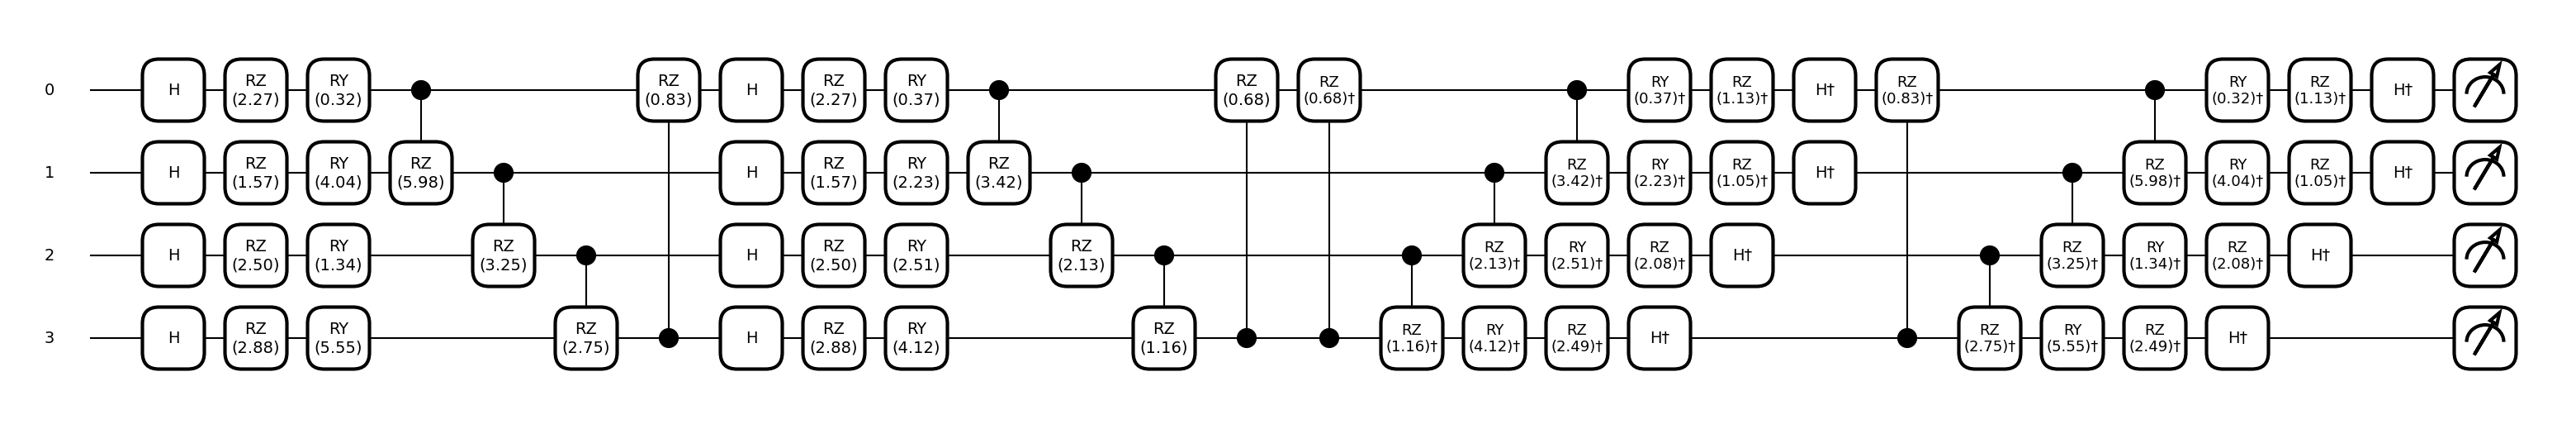

In [17]:
i,j = (120, 121)
print("Before training:")
print(f"    Twe two selected points have the same class: {y[i]==y[j]}")
print(f"    Kernel value between points: {kernel_3(X[i], X[j], params_2L)}")
qml.draw_mpl(kernel_circuit_3, decimals=2)(X[i],X[j], params_2L)
plt.show()

After training:
    Twe two selected points have the same class: True
    Kernel value between points: 0.6849348886243887


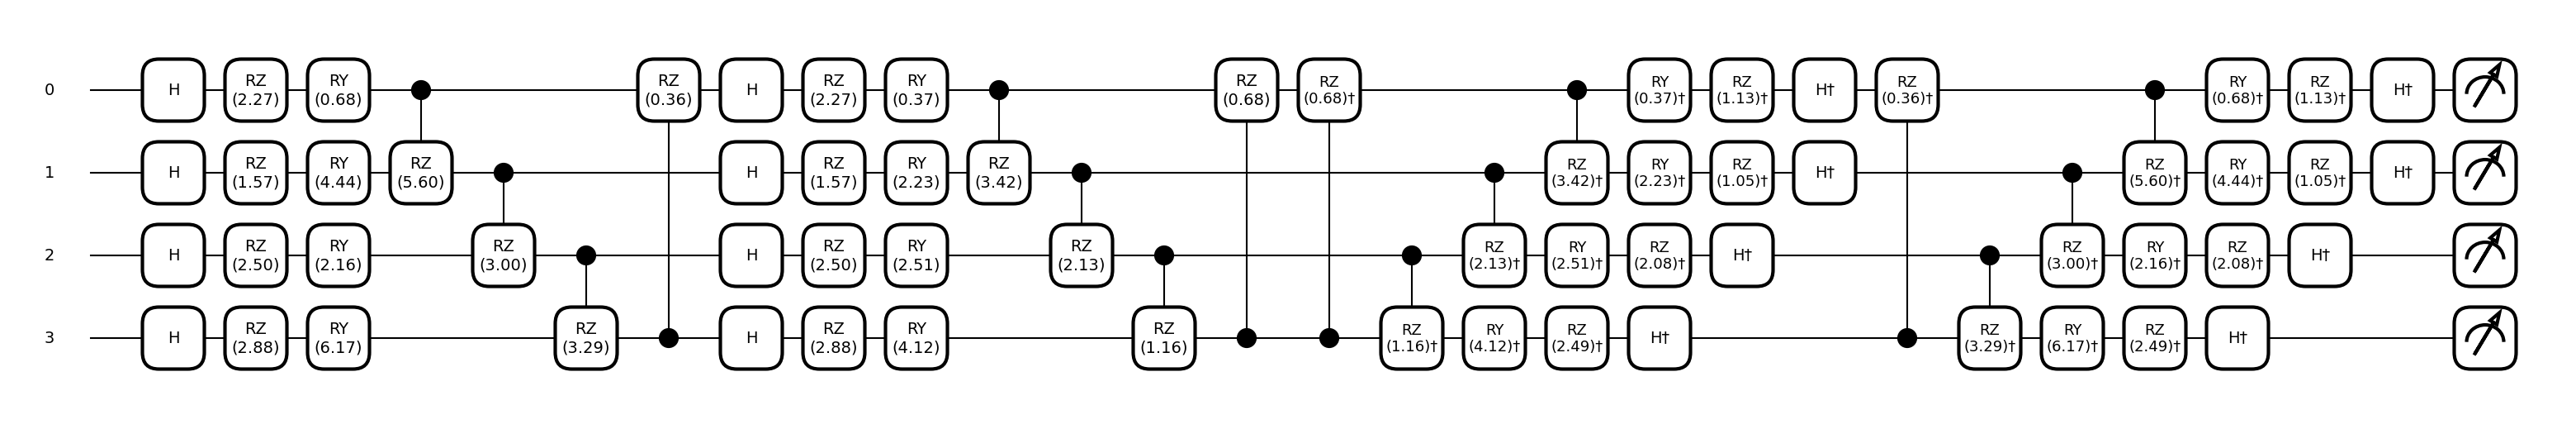

In [18]:
i,j = (120, 121)
print("After training:")
print(f"    Twe two selected points have the same class: {y[i]==y[j]}")
print(f"    Kernel value between points: {kernel_3(X[i], X[j], trained_params_2L)}")
qml.draw_mpl(kernel_circuit_3, decimals=2)(X[i],X[j], trained_params_2L)
plt.show()

<a id='p2'></a>
### 5 layers

In [19]:
params_5L = random_params(num_wires=n_qubits, num_layers=5)

In [20]:
trained_params_5L, alignment_fit, alignment_val = optimize(X_train, y_train, params_5L, kernel_3, max_iters = 500)

Iteration 190 / 500 , Exited optimization.


In [21]:
kernel_5L = lambda x1, x2: kernel_3(x1, x2, trained_params_5L)

Twe two selected points have the same class: True
Kernel value between points: 0.2614896023955018


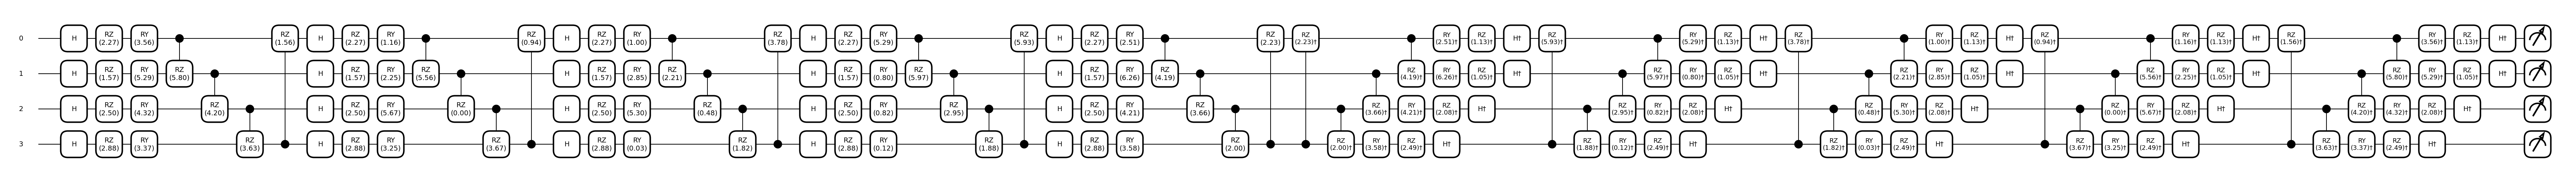

In [22]:
i,j = (120, 121)
print(f"Twe two selected points have the same class: {y[i]==y[j]}")
print(f"Kernel value between points: {kernel_3(X[i], X[j], params_5L)}")
qml.draw_mpl(kernel_circuit_3, decimals=2)(X[i],X[j], params_5L)
plt.show()

Twe two selected points have the same class: True
Kernel value between points: 0.6737256338800997


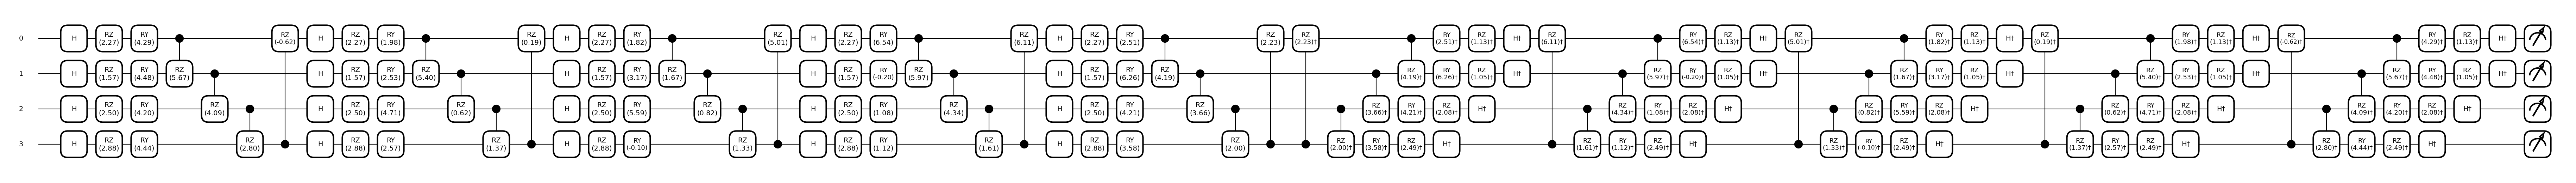

In [23]:
i,j = (120, 121)
print(f"Twe two selected points have the same class: {y[i]==y[j]}")
print(f"Kernel value between points: {kernel_3(X[i], X[j], trained_params_5L)}")
qml.draw_mpl(kernel_circuit_3, decimals=2)(X[i],X[j], trained_params_5L)
plt.show()

<a id='compare_kernels'></a>
# Compare kernels


In [24]:
kernel_matrix_1 = qml.kernels.square_kernel_matrix(X, kernel_1, assume_normalized_kernel=True)
kernel_matrix_2 = qml.kernels.square_kernel_matrix(X, kernel_2, assume_normalized_kernel=True)
kernel_matrix_3 = qml.kernels.square_kernel_matrix(X, kernel_2L, assume_normalized_kernel=True)
kernel_matrix_4 = qml.kernels.square_kernel_matrix(X, kernel_5L, assume_normalized_kernel=True)


C:\Users\barrieta\AppData\Local\Temp\ipykernel_4912\119999725.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


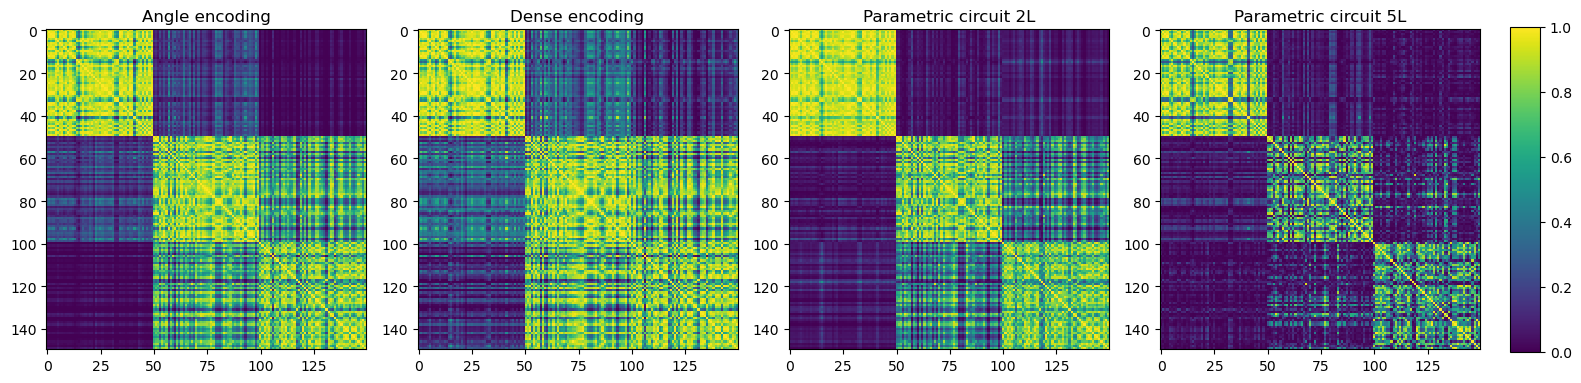

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))

# Plot each kernel matrix in its own subplot
axs[0].imshow(kernel_matrix_1, cmap='viridis', interpolation='nearest')
axs[0].set_title('Angle encoding')
axs[1].imshow(kernel_matrix_2, cmap='viridis', interpolation='nearest')
axs[1].set_title('Dense encoding')
axs[2].imshow(kernel_matrix_3, cmap='viridis', interpolation='nearest')
axs[2].set_title('Parametric circuit 2L')
axs[3].imshow(kernel_matrix_4, cmap='viridis', interpolation='nearest')
axs[3].set_title('Parametric circuit 5L')


# Add a colorbar on the right
cax = fig.add_axes([1.01, 0.175, 0.02, 0.65])
fig.colorbar(axs[0].images[0], cax=cax)

# Adjust the layout and spacing of the subplots
fig.tight_layout()

# Display the plot
plt.show()

We see that all four kernels identify very good the first class, but they have some troubles to distinguish between the second and third classes. The last kernel has the lowest values for instances of different classes, but the values for instances of the same class are also lower than for other kernels. Therefore, we cannot say which of these will work best in advance.
Let's see how they perform using SVC from scikit learn:

<a id='compare_acc'></a>
# Compare accuracies

In [29]:
kernels = [lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, kernel_1),
           lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, kernel_2),
           lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, kernel_2L),
           lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, kernel_5L)]

C_values = [0.1, 1, 10, 100]

accuracies = np.zeros((len(kernels), len(C_values)))

for i, kernel in enumerate(kernels):
    for j, C in enumerate([0.1, 1, 10, 100]):
        model = svm.SVC(C=C, kernel=kernel)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        acc = accuracy_score(predictions, y_test)
        accuracies[i,j] = acc
        print(f"\rIteration ({i+1, j+1})", end="", flush=True)
# Each row of accuracies contains the accuracies for differen Cs for each model.

Iteration ((4, 4))

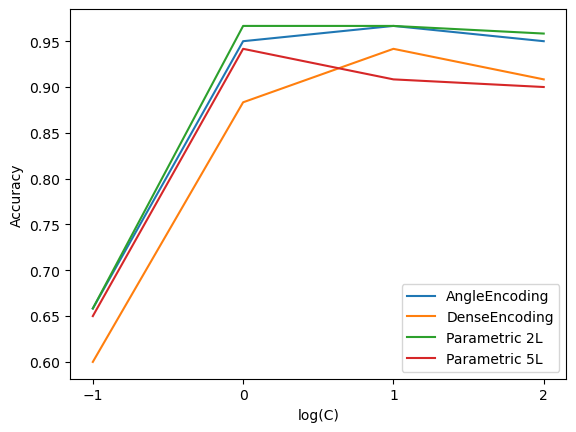

In [32]:
labels = ["AngleEncoding", "DenseEncoding", "Parametric 2L", "Parametric 5L"]
logC = [-1, 0, 1, 2]
for i in range(4):
    plt.plot(logC, accuracies[i], label = labels[i])
plt.xlabel("log(C)")
plt.ylabel("Accuracy")
plt.xticks(logC)
plt.legend()
plt.show()

<a id='conclusions'></a>
# Conclusions

<a id='bib'></a>
# Bibliography
<a id='qSVM1'></a>
Vojtěch Havlíček, Antonio D Córcoles, Kristan Temme, Aram W Harrow, Abhinav Kandala, Jerry M Chow, and Jay M Gambetta. **Supervised learning with quantum-enhanced feature spaces**. *Nature*, 567(7747):209–212, 2019.

<a id='qSVM_training_kernels'></a>
Thomas Hubregtsen, David Wierichs, Elies Gil-Fuster, Peter-Jan HS Derks, Paul K Faehrmann, and Johannes Jakob Meyer. **Training quantum embedding kernels on near-term quantum computers**. *Physical Review A*, 106(4):042431, 2022.

